In [1]:
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt

import os
import pandas as pd
import time as time
from datetime import timedelta

import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import matplotlib as mpl
import glob
import random
import sys
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from skimage.transform import resize

from os.path import expanduser
home = expanduser("~")
sys.path.append(home+'/repos/ClusNet/code/modules/')

from scipy.ndimage import gaussian_filter
from ClusNet import Cluster
from ClusNet import model as m
from ClusNet import dataset as ds
 
import gc
from keras import backend as K 

# tensorflow
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import model_from_yaml
from tensorflow.keras.callbacks import CSVLogger
clusfpath = home + '/repos/ClusNet/data/eROSITA_no_background/*.fits'
clusglob = glob.glob(clusfpath)
np.seterr(divide='ignore')
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import seg

In [11]:
# WELCOME
seg.p_GPU_stat()

N_CLASSES = 4

# DATASET SETTINGS
# image
IMG_SIZE = 128

# dataset
DATASET_SIZE = 500

# noise 
p = False
agn = True
shift = False

# segmentation
sigma = 0.25

# splitting/batching
batch_size = 16
validation_split = 0.1


********************

Num GPUs Available:  0
Num CPUs Available:  1
********************



In [12]:
img_train, msk_train, paths_train, img_val, msk_val, paths_val = seg.make_dataset(DATASET_SIZE=DATASET_SIZE)


Loading 500 cluster(s)...
 |████████████████████████-| 100% 

img_train shape: (400, 128, 128, 1)
msk_train shape: (400, 128, 128, 3)

img_val shape:   (100, 128, 128, 1)
mask_val shape:  (100, 128, 128, 3)


In [13]:
# COMPLILER SETTINGS 

# metrics
all_metrics = [tf.keras.metrics.Accuracy(name='acc'),
               tf.keras.metrics.MeanSquaredError(name='mse'),
               tf.keras.metrics.MeanIoU(name='iou',num_classes=N_CLASSES)]
metrics = all_metrics

# loss
#loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss = tf.keras.losses.MeanSquaredError()

# optimizer
optimizer=tf.keras.optimizers.Adam(lr=1e-3)

# layer
activation = 'relu'
#activation = tf.keras.layers.LeakyReLU(alpha=0.01)


kernel_initializer=tf.keras.initializers.GlorotUniform


# model
epochs = 10

crab = False

if crab:
    modeldir = Cluster.mkdir_model(spath=home+'scratch/seg')
else: 
    modeldir = Cluster.mkdir_model(spath=home+'/repos/ClusNet/models/seg')
    os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

model_id = os.path.basename(os.path.normpath(modeldir))

csv_logger = CSVLogger(modeldir + '/history_{}.log'.format(model_id),
                       separator=',',
                       append=False)


the_U = seg.get_unet(IMG_SIZE=IMG_SIZE,activation=activation,kernel_initializer=kernel_initializer)
the_U.compile(optimizer=optimizer, 
              loss=loss,metrics=all_metrics)
the_U.summary()


Model directory created --> /Users/erebor/repos/ClusNet/models/seg/BIRKE
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64, 64, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 32, 32, 32)   18464       sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 16, 16, 16)   4624        sequential_1[0][0]               
____________________

In [14]:
print("\n********LEARNING START********")
start = time.time()

# Train the model on the normalized training set.
history = the_U.fit(x=img_train,
                    y=msk_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_split=validation_split)


print("********LEARNING END********")

elapsed = time.time() - start
print("\nTIME:",str(timedelta(seconds=elapsed)))

print("\nModel assets saved to:", modeldir)
the_U.save(modeldir)


********LEARNING START********
Epoch 1/10
23/23 - 8s - loss: 0.0149 - acc: 0.7577 - mse: 0.0149 - iou: 0.3418 - val_loss: 0.0119 - val_acc: 0.9282 - val_mse: 0.0119 - val_iou: 0.4097
Epoch 2/10
23/23 - 7s - loss: 0.0110 - acc: 0.9235 - mse: 0.0110 - iou: 0.3754 - val_loss: 0.0104 - val_acc: 0.9482 - val_mse: 0.0104 - val_iou: 0.5629
Epoch 3/10
23/23 - 7s - loss: 0.0104 - acc: 0.9300 - mse: 0.0104 - iou: 0.5564 - val_loss: 0.0097 - val_acc: 0.9157 - val_mse: 0.0097 - val_iou: 0.5943
Epoch 4/10
23/23 - 7s - loss: 0.0099 - acc: 0.9356 - mse: 0.0099 - iou: 0.5616 - val_loss: 0.0093 - val_acc: 0.9297 - val_mse: 0.0093 - val_iou: 0.5864
Epoch 5/10
23/23 - 7s - loss: 0.0099 - acc: 0.9347 - mse: 0.0099 - iou: 0.5598 - val_loss: 0.0092 - val_acc: 0.9507 - val_mse: 0.0092 - val_iou: 0.5209
Epoch 6/10
23/23 - 7s - loss: 0.0097 - acc: 0.9399 - mse: 0.0097 - iou: 0.5646 - val_loss: 0.0090 - val_acc: 0.9474 - val_mse: 0.0090 - val_iou: 0.5233
Epoch 7/10
23/23 - 7s - loss: 0.0094 - acc: 0.9342 - mse

TypeError: get_config() missing 1 required positional argument: 'self'

In [ ]:
prediction = the_U(img_val, training=False)
seg.plot_results(x_val=img_val,
                 y_val=msk_val,
                 prediction=prediction,
                 seg_cmap=mpl.cm.rainbow,
                 spath=None)

tf.Tensor([0.05002702 0.11223485 0.06795182 ... 0.05306004 0.03742531 0.02756086], shape=(214745,), dtype=float32)


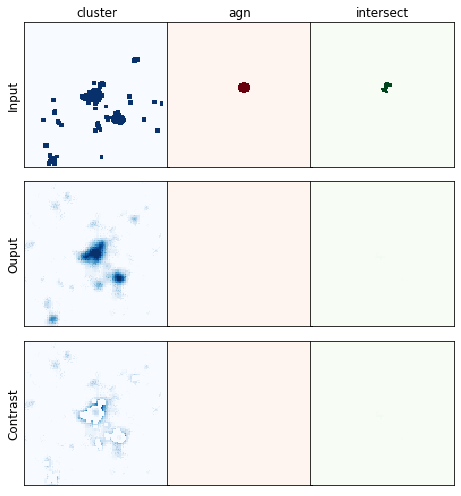

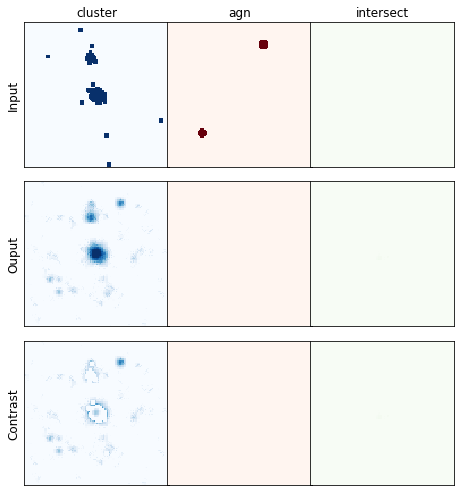

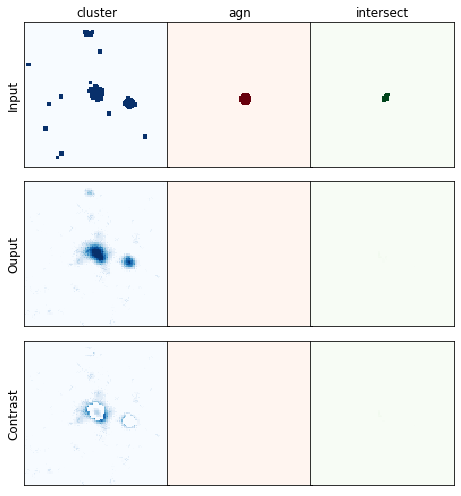

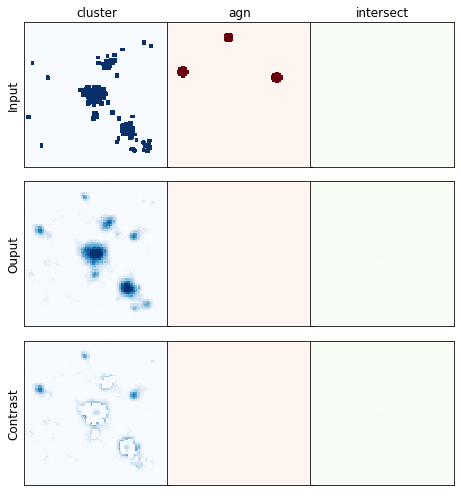

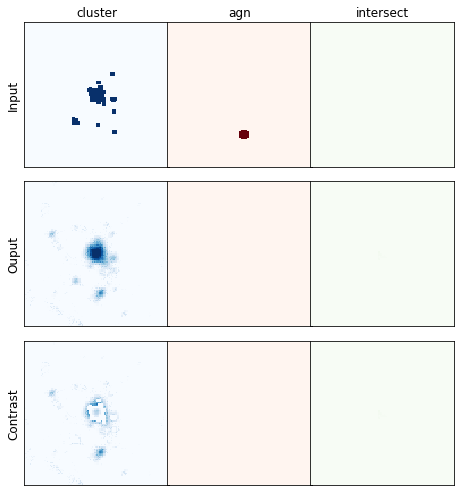

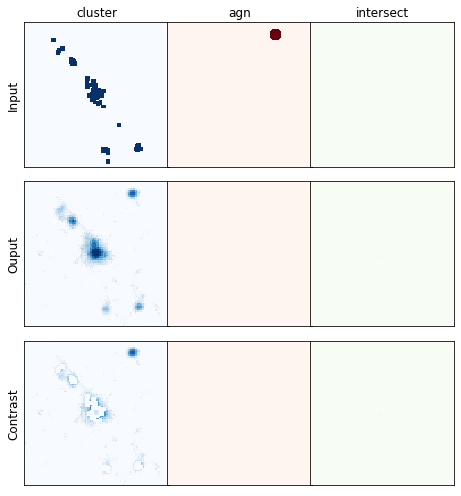

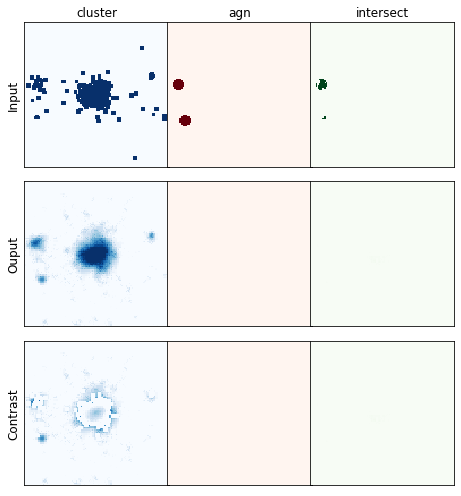

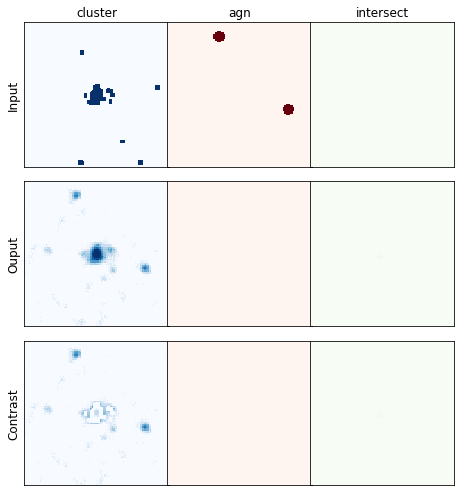

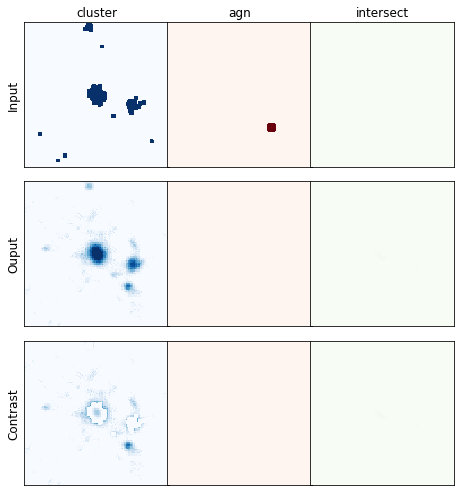

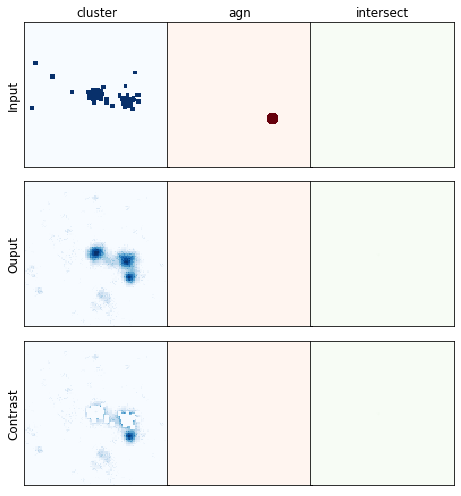

In [8]:
prediction = the_U(img_train, training=False)
print(prediction[prediction!=0])
seg.plot_results(x_val=img_train,
                 y_val=msk_train,
                 prediction=prediction,
                 seg_cmap=mpl.cm.rainbow,
                 spath=None)

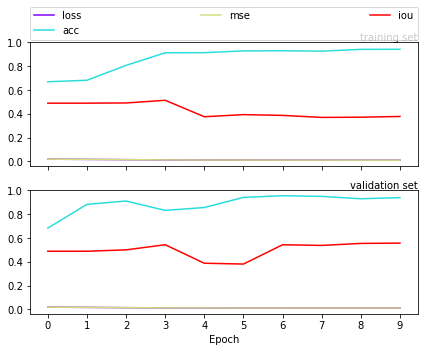

In [9]:
# plot loss and accuracy
seg.plot_metrics(history=history,
             spath=None,
             model_id=model_id,save=False)

In [10]:
del the_U
gc.collect()
K.clear_session()
tf.compat.v1.reset_default_graph() 

In [ ]:
metrics = history.history.keys()
print(metrics)

In [ ]:
len(history.history['loss'])